<a href="https://colab.research.google.com/github/Samuel1796/Abedepele/blob/master/stroke_detection_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="display: flex;
            align-items: center;
            justify-content: center;
            padding: 20px 30px;
            margin: 30px auto;
            max-width: 1000px;
            border-radius: 20px;
            background: linear-gradient(135deg, #003366 0%, #006699 50%, #00cccc 100%);
            color: #ffffff;
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            box-shadow: 0 4px 20px rgba(0,0,0,0.2);">
  
  <img src="https://i.vimeocdn.com/video/663892561-e13235b351d37090718f37942a5c40903728212d86e47584f2a7a812764d5667-d?mw=1920&mh=1080&q=70"
       alt="Brain Illustration"
       style="width:120px; height:auto; border-radius:12px; margin-right:25px; box-shadow: 0 2px 10px rgba(0,0,0,0.3);">

  <div style="text-align: left;">
    <div style="font-size: 1.7rem; font-weight: 600;">
      Deep Learning Model for Stroke Classification
    </div>
    <div style="font-size: 1.1rem; font-weight: 300; color: #e0f7fa;">
      A Comparative Analysis
    </div>
  </div>
</div>


In [ ]:
from google.colab import drive

In [ ]:
drive.mount ('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

print(np.__version__)
print(pd.__version__)
print(tf.__version__)

2.0.2
2.2.2
2.18.0


In [ ]:
# TensorFlow & Keras
from tensorflow.keras.applications import DenseNet121, ResNet50, Xception
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall

# Scikit-learn for evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Standard libraries
import os
import datetime
import matplotlib.pyplot as plt
import itertools
import time

print ('modules loaded')

modules loaded


In [ ]:
# Set seeds for reproducibility
tf.random.set_seed(42)

In [ ]:
# Data paths
train_dir =  r'/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Train'
test_dir = r'/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Test'
val_dir = r'/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Validation'

In [ ]:
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# Load datasets
train_ds = image_dataset_from_directory(train_dir,
                                        image_size=IMG_SIZE,
                                        batch_size=BATCH_SIZE,
                                        label_mode="binary")

val_ds = image_dataset_from_directory(val_dir,
                                      image_size=IMG_SIZE,
                                      batch_size=BATCH_SIZE,
                                      label_mode="binary")

test_ds = image_dataset_from_directory(test_dir,
                                       image_size=IMG_SIZE,
                                       batch_size=BATCH_SIZE,
                                       label_mode="binary")

Found 1850 files belonging to 2 classes.
Found 351 files belonging to 2 classes.
Found 127 files belonging to 2 classes.


In [ ]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i + 1 for i in range(len(tr_acc))]

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=f'Best epoch = {index_loss + 1}')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=f'Best epoch = {index_acc + 1}')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else str(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#28a745; overflow:hidden"><b> Data Preprocessing 📊 </b></div>

In [ ]:
# === PREFETCH & CACHE ===
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# === DATA AUGMENTATION ===
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])


<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#28a745; overflow:hidden"><b> Build Model 🎯 </b></div>

## DenseNet121 Model

In [ ]:
# === PREPROCESSING FUNCTION ===
preprocess_input = tf.keras.applications.densenet.preprocess_input


In [ ]:
# === BASE MODEL ===
base_model1 = DenseNet121(include_top=False,
                         weights='imagenet',
                         input_shape=(224, 224, 3))
base_model1.trainable = False  # Freeze for feature extraction

# === BUILD MODEL ===
inputs1 = Input(shape=(224, 224, 3))
x = data_augmentation(inputs1)
x = preprocess_input(x)
x = base_model1(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs1 = Dense(1, activation='sigmoid')(x)
model1 = Model(inputs1, outputs1)

# === COMPILE MODEL ===
model1.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

# Custom Callback to track validation accuracy improvement
class ValAccuracyImprovement(Callback):
    def __init__(self):
        super().__init__()
        self.best_val_accuracy = 0.0

    def on_epoch_end(self, epoch, logs=None):
        current_val_accuracy = logs.get('val_accuracy', 0.0)

        if current_val_accuracy > self.best_val_accuracy:
            print(f"\n Validation accuracy improved from {self.best_val_accuracy:.4f} to {current_val_accuracy:.4f}")
            self.best_val_accuracy = current_val_accuracy
        else:
            print(f"\n Validation accuracy did not improve (Best: {self.best_val_accuracy:.4f}, Current: {current_val_accuracy:.4f})")

val_accuracy_cb1 = ValAccuracyImprovement()  # Custom callback

# === CALLBACKS ===
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('densenet121_stroke_best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    TensorBoard(log_dir=log_dir),
    val_accuracy_cb1

]
training_start_time1 = time.time()

# === TRAIN PHASE 1: Feature Extraction ===

history1 = model1.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=callbacks)

# === UNFREEZE AND FINE-TUNE ===
base_model1.trainable = True
fine_tune_at = 100  # Unfreeze last 50 layers
for layer in base_model1.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile
model1.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

# === TRAIN PHASE 2: Fine-tuning ===
history_fine1 = model1.fit(train_ds,
                         validation_data=val_ds,
                         epochs=EPOCHS,
                         callbacks=callbacks)

training_end_time1 = time.time()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.4852 - auc: 0.4850 - loss: 0.9687 - precision: 0.4954 - recall: 0.5517


🔥 Validation accuracy improved from 0.0000 to 0.6866
58/58 ━━━━━━━━━━━━━━━━━━━━ 455s 3s/step - accuracy: 0.4858 - auc: 0.4858 - loss: 0.9674 - precision: 0.4961 - recall: 0.5522 - val_accuracy: 0.6866 - val_auc: 0.7091 - val_loss: 0.6300 - val_precision: 0.7011 - val_recall: 0.6778 - learning_rate: 1.0000e-04
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.6049 - auc: 0.6373 - loss: 0.7451 - precision: 0.6267 - recall: 0.6424


🔥 Validation accuracy improved from 0.6866 to 0.7322
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.6051 - auc: 0.6376 - loss: 0.7448 - precision: 0.6267 - recall: 0.6426 - val_accuracy: 0.7322 - val_auc: 0.7987 - val_loss: 0.5742 - val_precision: 0.8308 - val_recall: 0.6000 - learning_rate: 1.0000e-04
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6328 - auc: 0.6821 - loss: 0.6898 - precision: 0.6479 - recall: 0.6526


🔥 Validation accuracy improved from 0.7322 to 0.7863
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.6330 - auc: 0.6824 - loss: 0.6895 - precision: 0.6480 - recall: 0.6529 - val_accuracy: 0.7863 - val_auc: 0.8434 - val_loss: 0.5154 - val_precision: 0.8107 - val_recall: 0.7611 - learning_rate: 1.0000e-04
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6277 - auc: 0.7112 - loss: 0.6421 - precision: 0.6502 - recall: 0.6521


🔥 Validation accuracy improved from 0.7863 to 0.7949
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.6281 - auc: 0.7114 - loss: 0.6419 - precision: 0.6504 - recall: 0.6522 - val_accuracy: 0.7949 - val_auc: 0.8708 - val_loss: 0.4878 - val_precision: 0.8600 - val_recall: 0.7167 - learning_rate: 1.0000e-04
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6670 - auc: 0.7350 - loss: 0.6279 - precision: 0.6639 - recall: 0.6673


🔥 Validation accuracy improved from 0.7949 to 0.8148
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.6672 - auc: 0.7351 - loss: 0.6279 - precision: 0.6643 - recall: 0.6679 - val_accuracy: 0.8148 - val_auc: 0.8853 - val_loss: 0.4661 - val_precision: 0.8212 - val_recall: 0.8167 - learning_rate: 1.0000e-04
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7106 - auc: 0.7690 - loss: 0.5909 - precision: 0.7155 - recall: 0.7175
❌ Validation accuracy did not improve (Best: 0.8148, Current: 0.8120)
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.7104 - auc: 0.7690 - loss: 0.5907 - precision: 0.7154 - recall: 0.7176 - val_accuracy: 0.8120 - val_auc: 0.8970 - val_loss: 0.4559 - val_precision: 0.8519 - val_recall: 0.7667 - learning_rate: 1.0000e-04
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7121 - auc: 0.7801 - loss: 0.5713 - precision: 0.7178 - recall: 0.7313
❌ Validation accuracy did not improve (Best: 0.8148, Current: 0.8091)
58/58 ━━━━━━━


🔥 Validation accuracy improved from 0.8148 to 0.8319
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.7212 - auc: 0.8056 - loss: 0.5400 - precision: 0.7338 - recall: 0.7132 - val_accuracy: 0.8319 - val_auc: 0.9099 - val_loss: 0.4277 - val_precision: 0.8497 - val_recall: 0.8167 - learning_rate: 1.0000e-04
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7109 - auc: 0.7997 - loss: 0.5431 - precision: 0.7238 - recall: 0.7070


🔥 Validation accuracy improved from 0.8319 to 0.8348
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.7111 - auc: 0.7998 - loss: 0.5429 - precision: 0.7240 - recall: 0.7073 - val_accuracy: 0.8348 - val_auc: 0.9154 - val_loss: 0.4268 - val_precision: 0.8631 - val_recall: 0.8056 - learning_rate: 1.0000e-04
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7440 - auc: 0.8248 - loss: 0.5143 - precision: 0.7617 - recall: 0.7178


🔥 Validation accuracy improved from 0.8348 to 0.8433
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.7439 - auc: 0.8246 - loss: 0.5145 - precision: 0.7616 - recall: 0.7180 - val_accuracy: 0.8433 - val_auc: 0.9172 - val_loss: 0.4197 - val_precision: 0.8655 - val_recall: 0.8222 - learning_rate: 1.0000e-04
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7592 - auc: 0.8382 - loss: 0.5033 - precision: 0.7551 - recall: 0.7674


🔥 Validation accuracy improved from 0.8433 to 0.8462
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.7588 - auc: 0.8379 - loss: 0.5035 - precision: 0.7549 - recall: 0.7671 - val_accuracy: 0.8462 - val_auc: 0.9191 - val_loss: 0.4172 - val_precision: 0.8462 - val_recall: 0.8556 - learning_rate: 1.0000e-04
Epoch 13/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7626 - auc: 0.8387 - loss: 0.4977 - precision: 0.7660 - recall: 0.7793
❌ Validation accuracy did not improve (Best: 0.8462, Current: 0.8462)
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.7622 - auc: 0.8385 - loss: 0.4981 - precision: 0.7659 - recall: 0.7786 - val_accuracy: 0.8462 - val_auc: 0.9194 - val_loss: 0.4128 - val_precision: 0.8539 - val_recall: 0.8444 - learning_rate: 1.0000e-04
Epoch 14/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7599 - auc: 0.8365 - loss: 0.4991 - precision: 0.7599 - recall: 0.7639


🔥 Validation accuracy improved from 0.8462 to 0.8519
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.7596 - auc: 0.8363 - loss: 0.4994 - precision: 0.7599 - recall: 0.7634 - val_accuracy: 0.8519 - val_auc: 0.9223 - val_loss: 0.4156 - val_precision: 0.8765 - val_recall: 0.8278 - learning_rate: 1.0000e-04
Epoch 15/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7596 - auc: 0.8409 - loss: 0.4948 - precision: 0.7618 - recall: 0.7806


🔥 Validation accuracy improved from 0.8519 to 0.8547
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.7595 - auc: 0.8407 - loss: 0.4950 - precision: 0.7618 - recall: 0.7803 - val_accuracy: 0.8547 - val_auc: 0.9260 - val_loss: 0.4146 - val_precision: 0.8957 - val_recall: 0.8111 - learning_rate: 1.0000e-04
Epoch 16/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7665 - auc: 0.8420 - loss: 0.4918 - precision: 0.7719 - recall: 0.7795
❌ Validation accuracy did not improve (Best: 0.8547, Current: 0.8291)
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.7663 - auc: 0.8417 - loss: 0.4921 - precision: 0.7717 - recall: 0.7793 - val_accuracy: 0.8291 - val_auc: 0.9256 - val_loss: 0.4212 - val_precision: 0.9167 - val_recall: 0.7333 - learning_rate: 1.0000e-04
Epoch 17/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7489 - auc: 0.8334 - loss: 0.5068 - precision: 0.7657 - recall: 0.7377
❌ Validation accuracy did not improve (Best: 0.8547, Current: 0.8547)
58/58 ━━━━━


🔥 Validation accuracy improved from 0.8547 to 0.8575
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - accuracy: 0.7654 - auc: 0.8544 - loss: 0.4737 - precision: 0.8022 - recall: 0.7554 - val_accuracy: 0.8575 - val_auc: 0.9260 - val_loss: 0.4083 - val_precision: 0.9012 - val_recall: 0.8111 - learning_rate: 2.0000e-05
Epoch 22/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7652 - auc: 0.8434 - loss: 0.4935 - precision: 0.7916 - recall: 0.7567
❌ Validation accuracy did not improve (Best: 0.8575, Current: 0.8575)
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 0.7654 - auc: 0.8437 - loss: 0.4932 - precision: 0.7916 - recall: 0.7571 - val_accuracy: 0.8575 - val_auc: 0.9264 - val_loss: 0.4084 - val_precision: 0.9062 - val_recall: 0.8056 - learning_rate: 2.0000e-05
Epoch 23/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7595 - auc: 0.8451 - loss: 0.4906 - precision: 0.7907 - recall: 0.7536
❌ Validation accuracy did not improve (Best: 0.8575, Current: 0.8547)
58/58 ━━━━


🔥 Validation accuracy improved from 0.8575 to 0.8632
58/58 ━━━━━━━━━━━━━━━━━━━━ 94s 522ms/step - accuracy: 0.6754 - auc: 0.7735 - loss: 0.6148 - precision: 0.7463 - recall: 0.5459 - val_accuracy: 0.8632 - val_auc: 0.9294 - val_loss: 0.3644 - val_precision: 0.8548 - val_recall: 0.8833 - learning_rate: 1.0000e-05
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.7587 - auc: 0.8401 - loss: 0.5090 - precision: 0.8067 - recall: 0.7162


🔥 Validation accuracy improved from 0.8632 to 0.8689
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 410ms/step - accuracy: 0.7588 - auc: 0.8402 - loss: 0.5088 - precision: 0.8064 - recall: 0.7167 - val_accuracy: 0.8689 - val_auc: 0.9431 - val_loss: 0.3343 - val_precision: 0.8526 - val_recall: 0.9000 - learning_rate: 1.0000e-05
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.7784 - auc: 0.8661 - loss: 0.4586 - precision: 0.8217 - recall: 0.7621


🔥 Validation accuracy improved from 0.8689 to 0.8917
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 412ms/step - accuracy: 0.7785 - auc: 0.8661 - loss: 0.4585 - precision: 0.8214 - recall: 0.7623 - val_accuracy: 0.8917 - val_auc: 0.9530 - val_loss: 0.3025 - val_precision: 0.8698 - val_recall: 0.9278 - learning_rate: 1.0000e-05
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8265 - auc: 0.9008 - loss: 0.3999 - precision: 0.8615 - recall: 0.8025


🔥 Validation accuracy improved from 0.8917 to 0.9003
58/58 ━━━━━━━━━━━━━━━━━━━━ 25s 433ms/step - accuracy: 0.8266 - auc: 0.9009 - loss: 0.3998 - precision: 0.8613 - recall: 0.8028 - val_accuracy: 0.9003 - val_auc: 0.9630 - val_loss: 0.2698 - val_precision: 0.8919 - val_recall: 0.9167 - learning_rate: 1.0000e-05
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.8482 - auc: 0.9274 - loss: 0.3548 - precision: 0.8724 - recall: 0.8317


🔥 Validation accuracy improved from 0.9003 to 0.9031
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 418ms/step - accuracy: 0.8483 - auc: 0.9275 - loss: 0.3546 - precision: 0.8724 - recall: 0.8319 - val_accuracy: 0.9031 - val_auc: 0.9687 - val_loss: 0.2523 - val_precision: 0.8925 - val_recall: 0.9222 - learning_rate: 1.0000e-05
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.8688 - auc: 0.9443 - loss: 0.3111 - precision: 0.9057 - recall: 0.8382


🔥 Validation accuracy improved from 0.9031 to 0.9202
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 417ms/step - accuracy: 0.8688 - auc: 0.9443 - loss: 0.3111 - precision: 0.9055 - recall: 0.8384 - val_accuracy: 0.9202 - val_auc: 0.9749 - val_loss: 0.2245 - val_precision: 0.9270 - val_recall: 0.9167 - learning_rate: 1.0000e-05
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.8876 - auc: 0.9486 - loss: 0.2938 - precision: 0.8847 - recall: 0.8956


🔥 Validation accuracy improved from 0.9202 to 0.9259
58/58 ━━━━━━━━━━━━━━━━━━━━ 42s 431ms/step - accuracy: 0.8875 - auc: 0.9486 - loss: 0.2936 - precision: 0.8850 - recall: 0.8952 - val_accuracy: 0.9259 - val_auc: 0.9785 - val_loss: 0.2060 - val_precision: 0.9477 - val_recall: 0.9056 - learning_rate: 1.0000e-05
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9123 - auc: 0.9680 - loss: 0.2362 - precision: 0.9260 - recall: 0.8970


🔥 Validation accuracy improved from 0.9259 to 0.9373
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 417ms/step - accuracy: 0.9122 - auc: 0.9679 - loss: 0.2364 - precision: 0.9261 - recall: 0.8968 - val_accuracy: 0.9373 - val_auc: 0.9825 - val_loss: 0.1815 - val_precision: 0.9389 - val_recall: 0.9389 - learning_rate: 1.0000e-05
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9039 - auc: 0.9678 - loss: 0.2344 - precision: 0.9210 - recall: 0.8893


🔥 Validation accuracy improved from 0.9373 to 0.9459
58/58 ━━━━━━━━━━━━━━━━━━━━ 25s 438ms/step - accuracy: 0.9040 - auc: 0.9678 - loss: 0.2342 - precision: 0.9211 - recall: 0.8894 - val_accuracy: 0.9459 - val_auc: 0.9859 - val_loss: 0.1606 - val_precision: 0.9448 - val_recall: 0.9500 - learning_rate: 1.0000e-05
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9282 - auc: 0.9742 - loss: 0.2042 - precision: 0.9414 - recall: 0.9175


🔥 Validation accuracy improved from 0.9459 to 0.9487
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 419ms/step - accuracy: 0.9282 - auc: 0.9742 - loss: 0.2041 - precision: 0.9414 - recall: 0.9175 - val_accuracy: 0.9487 - val_auc: 0.9872 - val_loss: 0.1478 - val_precision: 0.9551 - val_recall: 0.9444 - learning_rate: 1.0000e-05
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9241 - auc: 0.9773 - loss: 0.1932 - precision: 0.9449 - recall: 0.9053
❌ Validation accuracy did not improve (Best: 0.9487, Current: 0.9459)
58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 395ms/step - accuracy: 0.9242 - auc: 0.9774 - loss: 0.1931 - precision: 0.9450 - recall: 0.9053 - val_accuracy: 0.9459 - val_auc: 0.9889 - val_loss: 0.1362 - val_precision: 0.9548 - val_recall: 0.9389 - learning_rate: 1.0000e-05
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9301 - auc: 0.9791 - loss: 0.1887 - precision: 0.9316 - recall: 0.9247


🔥 Validation accuracy improved from 0.9487 to 0.9630
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 415ms/step - accuracy: 0.9302 - auc: 0.9792 - loss: 0.1885 - precision: 0.9320 - recall: 0.9246 - val_accuracy: 0.9630 - val_auc: 0.9912 - val_loss: 0.1219 - val_precision: 0.9771 - val_recall: 0.9500 - learning_rate: 1.0000e-05
Epoch 13/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9503 - auc: 0.9865 - loss: 0.1463 - precision: 0.9624 - recall: 0.9409


🔥 Validation accuracy improved from 0.9630 to 0.9687
58/58 ━━━━━━━━━━━━━━━━━━━━ 25s 435ms/step - accuracy: 0.9502 - auc: 0.9865 - loss: 0.1464 - precision: 0.9623 - recall: 0.9408 - val_accuracy: 0.9687 - val_auc: 0.9926 - val_loss: 0.1109 - val_precision: 0.9721 - val_recall: 0.9667 - learning_rate: 1.0000e-05
Epoch 14/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9499 - auc: 0.9889 - loss: 0.1339 - precision: 0.9599 - recall: 0.9431


🔥 Validation accuracy improved from 0.9687 to 0.9744
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 415ms/step - accuracy: 0.9499 - auc: 0.9889 - loss: 0.1339 - precision: 0.9599 - recall: 0.9431 - val_accuracy: 0.9744 - val_auc: 0.9931 - val_loss: 0.1022 - val_precision: 0.9886 - val_recall: 0.9611 - learning_rate: 1.0000e-05
Epoch 15/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9613 - auc: 0.9921 - loss: 0.1182 - precision: 0.9670 - recall: 0.9577
❌ Validation accuracy did not improve (Best: 0.9744, Current: 0.9715)
58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 398ms/step - accuracy: 0.9613 - auc: 0.9921 - loss: 0.1182 - precision: 0.9670 - recall: 0.9576 - val_accuracy: 0.9715 - val_auc: 0.9929 - val_loss: 0.0955 - val_precision: 0.9775 - val_recall: 0.9667 - learning_rate: 1.0000e-05
Epoch 16/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9553 - auc: 0.9894 - loss: 0.1347 - precision: 0.9726 - recall: 0.9459


🔥 Validation accuracy improved from 0.9744 to 0.9772
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 419ms/step - accuracy: 0.9554 - auc: 0.9895 - loss: 0.1343 - precision: 0.9726 - recall: 0.9461 - val_accuracy: 0.9772 - val_auc: 0.9939 - val_loss: 0.0889 - val_precision: 0.9943 - val_recall: 0.9611 - learning_rate: 1.0000e-05
Epoch 17/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9683 - auc: 0.9914 - loss: 0.1012 - precision: 0.9855 - recall: 0.9508
❌ Validation accuracy did not improve (Best: 0.9772, Current: 0.9772)
58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 396ms/step - accuracy: 0.9682 - auc: 0.9915 - loss: 0.1013 - precision: 0.9854 - recall: 0.9508 - val_accuracy: 0.9772 - val_auc: 0.9950 - val_loss: 0.0831 - val_precision: 0.9831 - val_recall: 0.9722 - learning_rate: 1.0000e-05
Epoch 18/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9690 - auc: 0.9943 - loss: 0.0910 - precision: 0.9738 - recall: 0.9673


🔥 Validation accuracy improved from 0.9772 to 0.9801
58/58 ━━━━━━━━━━━━━━━━━━━━ 43s 432ms/step - accuracy: 0.9690 - auc: 0.9943 - loss: 0.0911 - precision: 0.9737 - recall: 0.9673 - val_accuracy: 0.9801 - val_auc: 0.9943 - val_loss: 0.0783 - val_precision: 0.9887 - val_recall: 0.9722 - learning_rate: 1.0000e-05
Epoch 19/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9764 - auc: 0.9956 - loss: 0.0852 - precision: 0.9847 - recall: 0.9708
❌ Validation accuracy did not improve (Best: 0.9801, Current: 0.9801)
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 415ms/step - accuracy: 0.9763 - auc: 0.9956 - loss: 0.0852 - precision: 0.9846 - recall: 0.9708 - val_accuracy: 0.9801 - val_auc: 0.9959 - val_loss: 0.0724 - val_precision: 0.9887 - val_recall: 0.9722 - learning_rate: 1.0000e-05
Epoch 20/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9773 - auc: 0.9972 - loss: 0.0750 - precision: 0.9800 - recall: 0.9749
❌ Validation accuracy did not improve (Best: 0.9801, Current: 0.9772)
58/58 ━━━━


🔥 Validation accuracy improved from 0.9801 to 0.9829
58/58 ━━━━━━━━━━━━━━━━━━━━ 41s 409ms/step - accuracy: 0.9874 - auc: 0.9966 - loss: 0.0529 - precision: 0.9931 - recall: 0.9819 - val_accuracy: 0.9829 - val_auc: 0.9977 - val_loss: 0.0599 - val_precision: 0.9943 - val_recall: 0.9722 - learning_rate: 1.0000e-05
Epoch 28/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9876 - auc: 0.9979 - loss: 0.0463 - precision: 0.9890 - recall: 0.9874
❌ Validation accuracy did not improve (Best: 0.9829, Current: 0.9829)
58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 395ms/step - accuracy: 0.9876 - auc: 0.9979 - loss: 0.0462 - precision: 0.9890 - recall: 0.9875 - val_accuracy: 0.9829 - val_auc: 0.9975 - val_loss: 0.0526 - val_precision: 0.9943 - val_recall: 0.9722 - learning_rate: 1.0000e-05
Epoch 29/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9880 - auc: 0.9986 - loss: 0.0418 - precision: 0.9924 - recall: 0.9835
❌ Validation accuracy did not improve (Best: 0.9829, Current: 0.9829)
58/58 ━━━━


🔥 Validation accuracy improved from 0.9829 to 0.9858
58/58 ━━━━━━━━━━━━━━━━━━━━ 24s 412ms/step - accuracy: 0.9902 - auc: 0.9996 - loss: 0.0313 - precision: 0.9910 - recall: 0.9898 - val_accuracy: 0.9858 - val_auc: 0.9982 - val_loss: 0.0544 - val_precision: 1.0000 - val_recall: 0.9722 - learning_rate: 1.0000e-05
Epoch 32/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9891 - auc: 0.9988 - loss: 0.0349 - precision: 0.9858 - recall: 0.9935
❌ Validation accuracy did not improve (Best: 0.9858, Current: 0.9858)
58/58 ━━━━━━━━━━━━━━━━━━━━ 40s 391ms/step - accuracy: 0.9892 - auc: 0.9988 - loss: 0.0350 - precision: 0.9858 - recall: 0.9935 - val_accuracy: 0.9858 - val_auc: 0.9982 - val_loss: 0.0522 - val_precision: 0.9944 - val_recall: 0.9778 - learning_rate: 1.0000e-05
Epoch 33/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9939 - auc: 0.9998 - loss: 0.0238 - precision: 0.9948 - recall: 0.9937
❌ Validation accuracy did not improve (Best: 0.9858, Current: 0.9829)
58/58 ━━━━

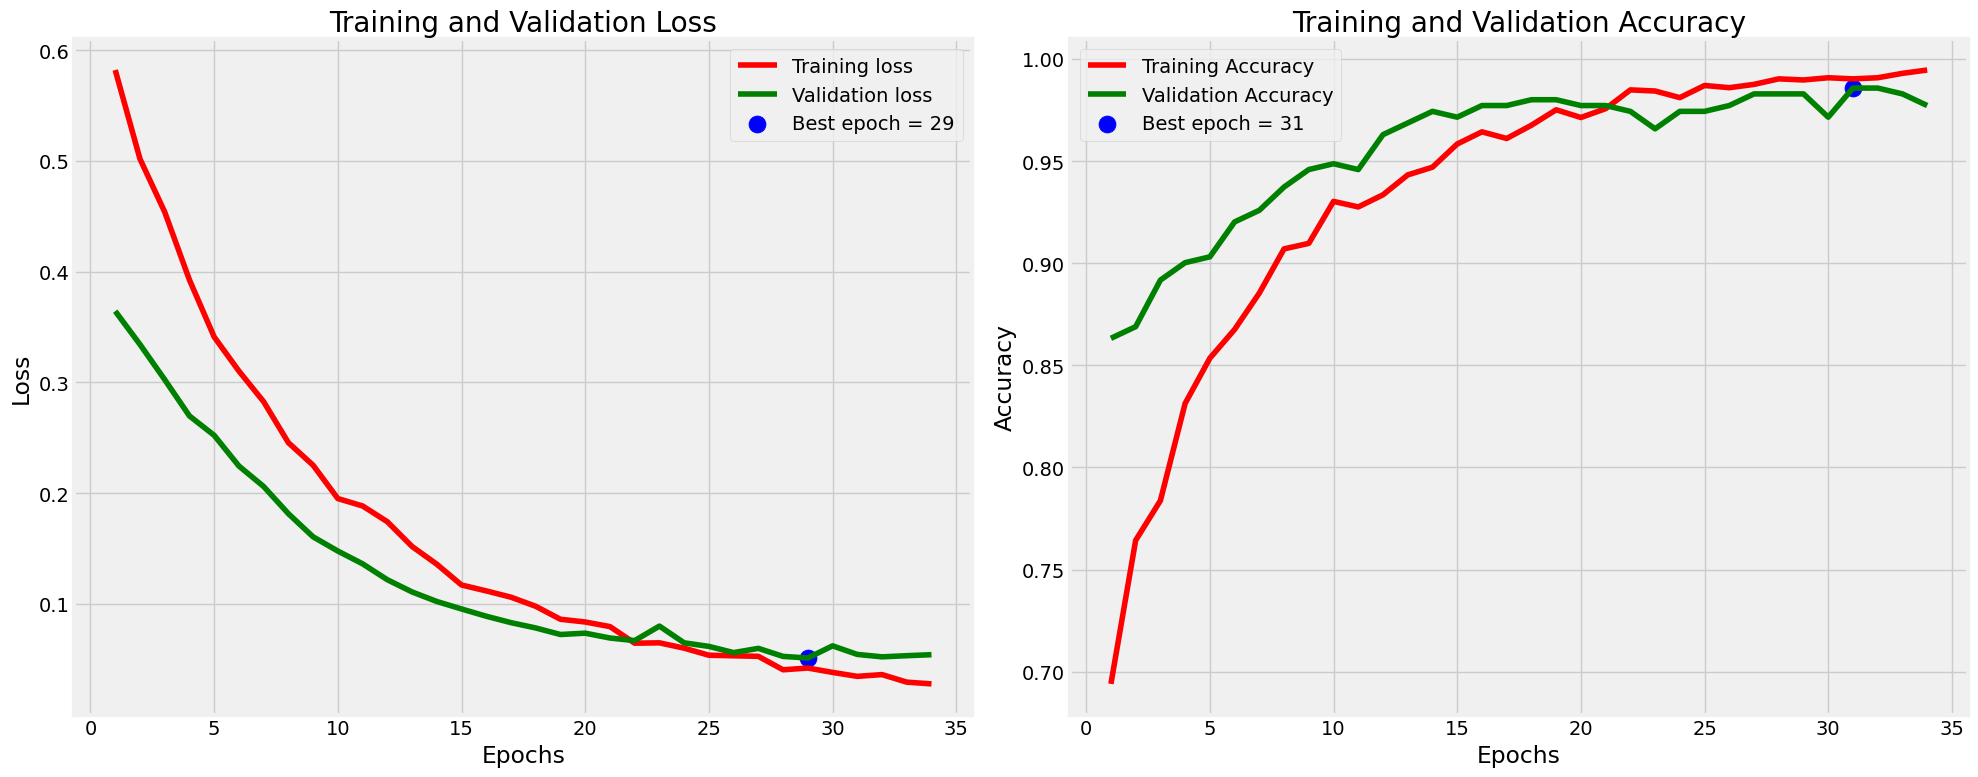

In [ ]:
plot_training(history_fine1)

In [ ]:
# ==========INITIAL EVALUATION ==========
loss1, acc1, precision1, recall1, auc1 = model1.evaluate(val_ds)
print(f"Validation Accuracy: {acc1 * 100:.2f}%")
print(f"Validation Precision: {precision1 * 100:.2f}%")
print(f"Validation Recall: {recall1 * 100:.2f}%")
print(f"Validation AUC: {auc1 * 100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9777 - auc: 0.9989 - loss: 0.0580 - precision: 0.9956 - recall: 0.9608
Validation Accuracy: 98.29%
Validation Precision: 99.43%
Validation Recall: 97.22%
Validation AUC: 99.81%



## RESNet 50 Model

In [ ]:

# Preprocessing
preprocess_input = tf.keras.applications.resnet.preprocess_input


In [ ]:

# Base model
base_model2 = ResNet50(include_top=False,
                      weights="imagenet",
                      input_shape=(224, 224, 3))

# Freeze base model
base_model2.trainable = False

# Build full model
inputs2 = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs2)
x = preprocess_input(x)
x = base_model2(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs2 = Dense(1, activation='sigmoid')(x)

model2 = Model(inputs2, outputs2)

# Compile model
model2.compile(optimizer=Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])


# Custom Callback to track validation accuracy improvement
class ValAccuracyImprovement(Callback):
    def __init__(self):
        super().__init__()
        self.best_val_accuracy = 0.0

    def on_epoch_end(self, epoch, logs=None):
        current_val_accuracy = logs.get('val_accuracy', 0.0)

        if current_val_accuracy > self.best_val_accuracy:
            print(f"\n Validation accuracy improved from {self.best_val_accuracy:.4f} to {current_val_accuracy:.4f}")
            self.best_val_accuracy = current_val_accuracy
        else:
            print(f"\n Validation accuracy did not improve (Best: {self.best_val_accuracy:.4f}, Current: {current_val_accuracy:.4f})")

val_accuracy_cb2 = ValAccuracyImprovement()  # Custom callback

# Callbacks
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
checkpoint_cb = ModelCheckpoint("resnet50_stroke_best_model.h5",
                                monitor="val_accuracy",
                                save_best_only=True,
                                mode="max")
early_stopping_cb = EarlyStopping(monitor="val_loss",
                                  patience=5,
                                  restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.2,
                                 patience=3,
                                 min_lr=1e-6)

training_start_time2 = time.time()

# Train (feature extractor mode)
history2 = model2.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb, tensorboard_cb, val_accuracy_cb2
])

# Fine-tune some layers of ResNet50
base_model2.trainable = True
fine_tune_at = 100  # Unfreeze last 50 layers
for layer in base_model2.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile for fine-tuning
model2.compile(optimizer=Adam(learning_rate=1e-5),
              loss="binary_crossentropy",
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

# Fine-tuning
history_fine2 = model2.fit(train_ds,
                         validation_data=val_ds,
                         epochs=EPOCHS,
                         callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb, tensorboard_cb, val_accuracy_cb2])
training_end_time2 = time.time()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5897 - auc: 0.6162 - loss: 0.7732 - precision: 0.6170 - recall: 0.6108


🔥 Validation accuracy improved from 0.0000 to 0.7721
58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.5905 - auc: 0.6172 - loss: 0.7722 - precision: 0.6175 - recall: 0.6114 - val_accuracy: 0.7721 - val_auc: 0.8548 - val_loss: 0.4975 - val_precision: 0.8906 - val_recall: 0.6333 - learning_rate: 1.0000e-04
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7080 - auc: 0.7676 - loss: 0.5979 - precision: 0.7384 - recall: 0.7001


🔥 Validation accuracy improved from 0.7721 to 0.8148
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.7083 - auc: 0.7679 - loss: 0.5974 - precision: 0.7385 - recall: 0.7005 - val_accuracy: 0.8148 - val_auc: 0.8890 - val_loss: 0.4241 - val_precision: 0.8528 - val_recall: 0.7722 - learning_rate: 1.0000e-04
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7208 - auc: 0.8097 - loss: 0.5327 - precision: 0.7325 - recall: 0.7303


🔥 Validation accuracy improved from 0.8148 to 0.8177
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.7211 - auc: 0.8098 - loss: 0.5326 - precision: 0.7328 - recall: 0.7304 - val_accuracy: 0.8177 - val_auc: 0.9069 - val_loss: 0.4057 - val_precision: 0.8867 - val_recall: 0.7389 - learning_rate: 1.0000e-04
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7490 - auc: 0.8315 - loss: 0.5029 - precision: 0.7599 - recall: 0.7444


🔥 Validation accuracy improved from 0.8177 to 0.8205
58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - accuracy: 0.7492 - auc: 0.8317 - loss: 0.5028 - precision: 0.7602 - recall: 0.7445 - val_accuracy: 0.8205 - val_auc: 0.9134 - val_loss: 0.3928 - val_precision: 0.8980 - val_recall: 0.7333 - learning_rate: 1.0000e-04
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7698 - auc: 0.8388 - loss: 0.4952 - precision: 0.7897 - recall: 0.7735
❌ Validation accuracy did not improve (Best: 0.8205, Current: 0.8091)
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.7699 - auc: 0.8389 - loss: 0.4951 - precision: 0.7898 - recall: 0.7734 - val_accuracy: 0.8091 - val_auc: 0.9232 - val_loss: 0.4069 - val_precision: 0.9380 - val_recall: 0.6722 - learning_rate: 1.0000e-04
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7753 - auc: 0.8402 - loss: 0.4956 - precision: 0.7973 - recall: 0.7327


🔥 Validation accuracy improved from 0.8205 to 0.8462
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.7752 - auc: 0.8403 - loss: 0.4953 - precision: 0.7974 - recall: 0.7330 - val_accuracy: 0.8462 - val_auc: 0.9255 - val_loss: 0.3608 - val_precision: 0.8795 - val_recall: 0.8111 - learning_rate: 1.0000e-04
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7667 - auc: 0.8628 - loss: 0.4578 - precision: 0.7913 - recall: 0.7646
❌ Validation accuracy did not improve (Best: 0.8462, Current: 0.8462)
58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 0.7669 - auc: 0.8629 - loss: 0.4577 - precision: 0.7914 - recall: 0.7646 - val_accuracy: 0.8462 - val_auc: 0.9315 - val_loss: 0.3572 - val_precision: 0.9038 - val_recall: 0.7833 - learning_rate: 1.0000e-04
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8067 - auc: 0.8890 - loss: 0.4182 - precision: 0.8115 - recall: 0.8215
❌ Validation accuracy did not improve (Best: 0.8462, Current: 0.8462)
58/58 ━━━━━━


🔥 Validation accuracy improved from 0.8462 to 0.8547
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.8106 - auc: 0.8811 - loss: 0.4350 - precision: 0.8313 - recall: 0.8164 - val_accuracy: 0.8547 - val_auc: 0.9381 - val_loss: 0.3436 - val_precision: 0.9108 - val_recall: 0.7944 - learning_rate: 1.0000e-04
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8124 - auc: 0.8871 - loss: 0.4211 - precision: 0.8252 - recall: 0.8002
❌ Validation accuracy did not improve (Best: 0.8547, Current: 0.8462)
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.8122 - auc: 0.8871 - loss: 0.4212 - precision: 0.8251 - recall: 0.8003 - val_accuracy: 0.8462 - val_auc: 0.9397 - val_loss: 0.3451 - val_precision: 0.9200 - val_recall: 0.7667 - learning_rate: 1.0000e-04
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8175 - auc: 0.8992 - loss: 0.4019 - precision: 0.8513 - recall: 0.7898


🔥 Validation accuracy improved from 0.8547 to 0.8604
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.8175 - auc: 0.8992 - loss: 0.4019 - precision: 0.8510 - recall: 0.7900 - val_accuracy: 0.8604 - val_auc: 0.9407 - val_loss: 0.3334 - val_precision: 0.9172 - val_recall: 0.8000 - learning_rate: 1.0000e-04
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8244 - auc: 0.8972 - loss: 0.4025 - precision: 0.8454 - recall: 0.8210
❌ Validation accuracy did not improve (Best: 0.8604, Current: 0.8575)
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.8244 - auc: 0.8972 - loss: 0.4026 - precision: 0.8454 - recall: 0.8207 - val_accuracy: 0.8575 - val_auc: 0.9434 - val_loss: 0.3281 - val_precision: 0.9114 - val_recall: 0.8000 - learning_rate: 1.0000e-04
Epoch 13/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8149 - auc: 0.9036 - loss: 0.3922 - precision: 0.8324 - recall: 0.7977
❌ Validation accuracy did not improve (Best: 0.8604, Current: 0.8575)
58/58 ━━━━━


🔥 Validation accuracy improved from 0.8604 to 0.8718
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.8267 - auc: 0.9043 - loss: 0.3874 - precision: 0.8591 - recall: 0.8166 - val_accuracy: 0.8718 - val_auc: 0.9485 - val_loss: 0.3157 - val_precision: 0.9245 - val_recall: 0.8167 - learning_rate: 1.0000e-04
Epoch 15/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8277 - auc: 0.9074 - loss: 0.3824 - precision: 0.8480 - recall: 0.8243
❌ Validation accuracy did not improve (Best: 0.8718, Current: 0.8405)
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.8276 - auc: 0.9074 - loss: 0.3825 - precision: 0.8479 - recall: 0.8241 - val_accuracy: 0.8405 - val_auc: 0.9477 - val_loss: 0.3333 - val_precision: 0.9306 - val_recall: 0.7444 - learning_rate: 1.0000e-04
Epoch 16/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8311 - auc: 0.9229 - loss: 0.3519 - precision: 0.8454 - recall: 0.8276
❌ Validation accuracy did not improve (Best: 0.8718, Current: 0.8405)
58/58 ━━━━━


🔥 Validation accuracy improved from 0.8718 to 0.8775
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - accuracy: 0.8361 - auc: 0.9179 - loss: 0.3621 - precision: 0.8582 - recall: 0.8226 - val_accuracy: 0.8775 - val_auc: 0.9510 - val_loss: 0.3037 - val_precision: 0.9308 - val_recall: 0.8222 - learning_rate: 2.0000e-05
Epoch 25/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8587 - auc: 0.9237 - loss: 0.3500 - precision: 0.8716 - recall: 0.8625
❌ Validation accuracy did not improve (Best: 0.8775, Current: 0.8746)
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.8586 - auc: 0.9237 - loss: 0.3502 - precision: 0.8714 - recall: 0.8622 - val_accuracy: 0.8746 - val_auc: 0.9512 - val_loss: 0.3050 - val_precision: 0.9304 - val_recall: 0.8167 - learning_rate: 2.0000e-05
Epoch 26/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8395 - auc: 0.9188 - loss: 0.3600 - precision: 0.8753 - recall: 0.8168
❌ Validation accuracy did not improve (Best: 0.8775, Current: 0.8746)
58/58 ━━━━━


🔥 Validation accuracy improved from 0.8775 to 0.8974
58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 286ms/step - accuracy: 0.8498 - auc: 0.9309 - loss: 0.3377 - precision: 0.8435 - recall: 0.8550 - val_accuracy: 0.8974 - val_auc: 0.9652 - val_loss: 0.2461 - val_precision: 0.9500 - val_recall: 0.8444 - learning_rate: 1.0000e-05
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8998 - auc: 0.9619 - loss: 0.2502 - precision: 0.8979 - recall: 0.9065


🔥 Validation accuracy improved from 0.8974 to 0.9088
58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 276ms/step - accuracy: 0.8997 - auc: 0.9619 - loss: 0.2503 - precision: 0.8979 - recall: 0.9063 - val_accuracy: 0.9088 - val_auc: 0.9702 - val_loss: 0.2186 - val_precision: 0.9205 - val_recall: 0.9000 - learning_rate: 1.0000e-05
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9079 - auc: 0.9684 - loss: 0.2275 - precision: 0.9074 - recall: 0.9044


🔥 Validation accuracy improved from 0.9088 to 0.9174
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 278ms/step - accuracy: 0.9080 - auc: 0.9684 - loss: 0.2274 - precision: 0.9077 - recall: 0.9044 - val_accuracy: 0.9174 - val_auc: 0.9744 - val_loss: 0.1956 - val_precision: 0.9266 - val_recall: 0.9111 - learning_rate: 1.0000e-05
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9241 - auc: 0.9780 - loss: 0.1889 - precision: 0.9275 - recall: 0.9146


🔥 Validation accuracy improved from 0.9174 to 0.9202
58/58 ━━━━━━━━━━━━━━━━━━━━ 22s 298ms/step - accuracy: 0.9240 - auc: 0.9780 - loss: 0.1889 - precision: 0.9277 - recall: 0.9145 - val_accuracy: 0.9202 - val_auc: 0.9765 - val_loss: 0.2009 - val_precision: 0.9000 - val_recall: 0.9500 - learning_rate: 1.0000e-05
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9437 - auc: 0.9870 - loss: 0.1479 - precision: 0.9478 - recall: 0.9436


🔥 Validation accuracy improved from 0.9202 to 0.9259
58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 280ms/step - accuracy: 0.9437 - auc: 0.9869 - loss: 0.1482 - precision: 0.9477 - recall: 0.9435 - val_accuracy: 0.9259 - val_auc: 0.9835 - val_loss: 0.1605 - val_precision: 0.9425 - val_recall: 0.9111 - learning_rate: 1.0000e-05
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9490 - auc: 0.9868 - loss: 0.1422 - precision: 0.9591 - recall: 0.9415


🔥 Validation accuracy improved from 0.9259 to 0.9288
58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 278ms/step - accuracy: 0.9491 - auc: 0.9868 - loss: 0.1421 - precision: 0.9591 - recall: 0.9415 - val_accuracy: 0.9288 - val_auc: 0.9851 - val_loss: 0.1497 - val_precision: 0.9379 - val_recall: 0.9222 - learning_rate: 1.0000e-05
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9441 - auc: 0.9911 - loss: 0.1231 - precision: 0.9579 - recall: 0.9360


🔥 Validation accuracy improved from 0.9288 to 0.9373
58/58 ━━━━━━━━━━━━━━━━━━━━ 18s 314ms/step - accuracy: 0.9443 - auc: 0.9911 - loss: 0.1229 - precision: 0.9580 - recall: 0.9362 - val_accuracy: 0.9373 - val_auc: 0.9866 - val_loss: 0.1421 - val_precision: 0.9389 - val_recall: 0.9389 - learning_rate: 1.0000e-05
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9634 - auc: 0.9912 - loss: 0.1096 - precision: 0.9743 - recall: 0.9543
❌ Validation accuracy did not improve (Best: 0.9373, Current: 0.9316)
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 263ms/step - accuracy: 0.9634 - auc: 0.9912 - loss: 0.1095 - precision: 0.9744 - recall: 0.9543 - val_accuracy: 0.9316 - val_auc: 0.9882 - val_loss: 0.1336 - val_precision: 0.9432 - val_recall: 0.9222 - learning_rate: 1.0000e-05
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9614 - auc: 0.9944 - loss: 0.0956 - precision: 0.9650 - recall: 0.9581
❌ Validation accuracy did not improve (Best: 0.9373, Current: 0.9288)
58/58 ━━━━━


🔥 Validation accuracy improved from 0.9373 to 0.9430
58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 282ms/step - accuracy: 0.9754 - auc: 0.9970 - loss: 0.0680 - precision: 0.9789 - recall: 0.9736 - val_accuracy: 0.9430 - val_auc: 0.9860 - val_loss: 0.1390 - val_precision: 0.9444 - val_recall: 0.9444 - learning_rate: 1.0000e-05
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9773 - auc: 0.9981 - loss: 0.0637 - precision: 0.9869 - recall: 0.9685


🔥 Validation accuracy improved from 0.9430 to 0.9459
58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 278ms/step - accuracy: 0.9773 - auc: 0.9981 - loss: 0.0637 - precision: 0.9868 - recall: 0.9685 - val_accuracy: 0.9459 - val_auc: 0.9865 - val_loss: 0.1319 - val_precision: 0.9600 - val_recall: 0.9333 - learning_rate: 1.0000e-05
Epoch 13/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9800 - auc: 0.9983 - loss: 0.0580 - precision: 0.9814 - recall: 0.9810
❌ Validation accuracy did not improve (Best: 0.9459, Current: 0.9459)
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 260ms/step - accuracy: 0.9799 - auc: 0.9982 - loss: 0.0581 - precision: 0.9813 - recall: 0.9809 - val_accuracy: 0.9459 - val_auc: 0.9862 - val_loss: 0.1386 - val_precision: 0.9708 - val_recall: 0.9222 - learning_rate: 1.0000e-05
Epoch 14/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9860 - auc: 0.9986 - loss: 0.0524 - precision: 0.9902 - recall: 0.9822
❌ Validation accuracy did not improve (Best: 0.9459, Current: 0.9373)
58/58 ━━━━


🔥 Validation accuracy improved from 0.9459 to 0.9601
58/58 ━━━━━━━━━━━━━━━━━━━━ 17s 286ms/step - accuracy: 0.9875 - auc: 0.9994 - loss: 0.0358 - precision: 0.9949 - recall: 0.9812 - val_accuracy: 0.9601 - val_auc: 0.9891 - val_loss: 0.1358 - val_precision: 0.9716 - val_recall: 0.9500 - learning_rate: 1.0000e-05
Epoch 18/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9907 - auc: 0.9997 - loss: 0.0274 - precision: 0.9910 - recall: 0.9904
❌ Validation accuracy did not improve (Best: 0.9601, Current: 0.9573)
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 260ms/step - accuracy: 0.9907 - auc: 0.9997 - loss: 0.0274 - precision: 0.9910 - recall: 0.9903 - val_accuracy: 0.9573 - val_auc: 0.9877 - val_loss: 0.1313 - val_precision: 0.9714 - val_recall: 0.9444 - learning_rate: 2.0000e-06
Epoch 19/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9909 - auc: 0.9997 - loss: 0.0284 - precision: 0.9957 - recall: 0.9864
❌ Validation accuracy did not improve (Best: 0.9601, Current: 0.9544)
58/58 ━━━━

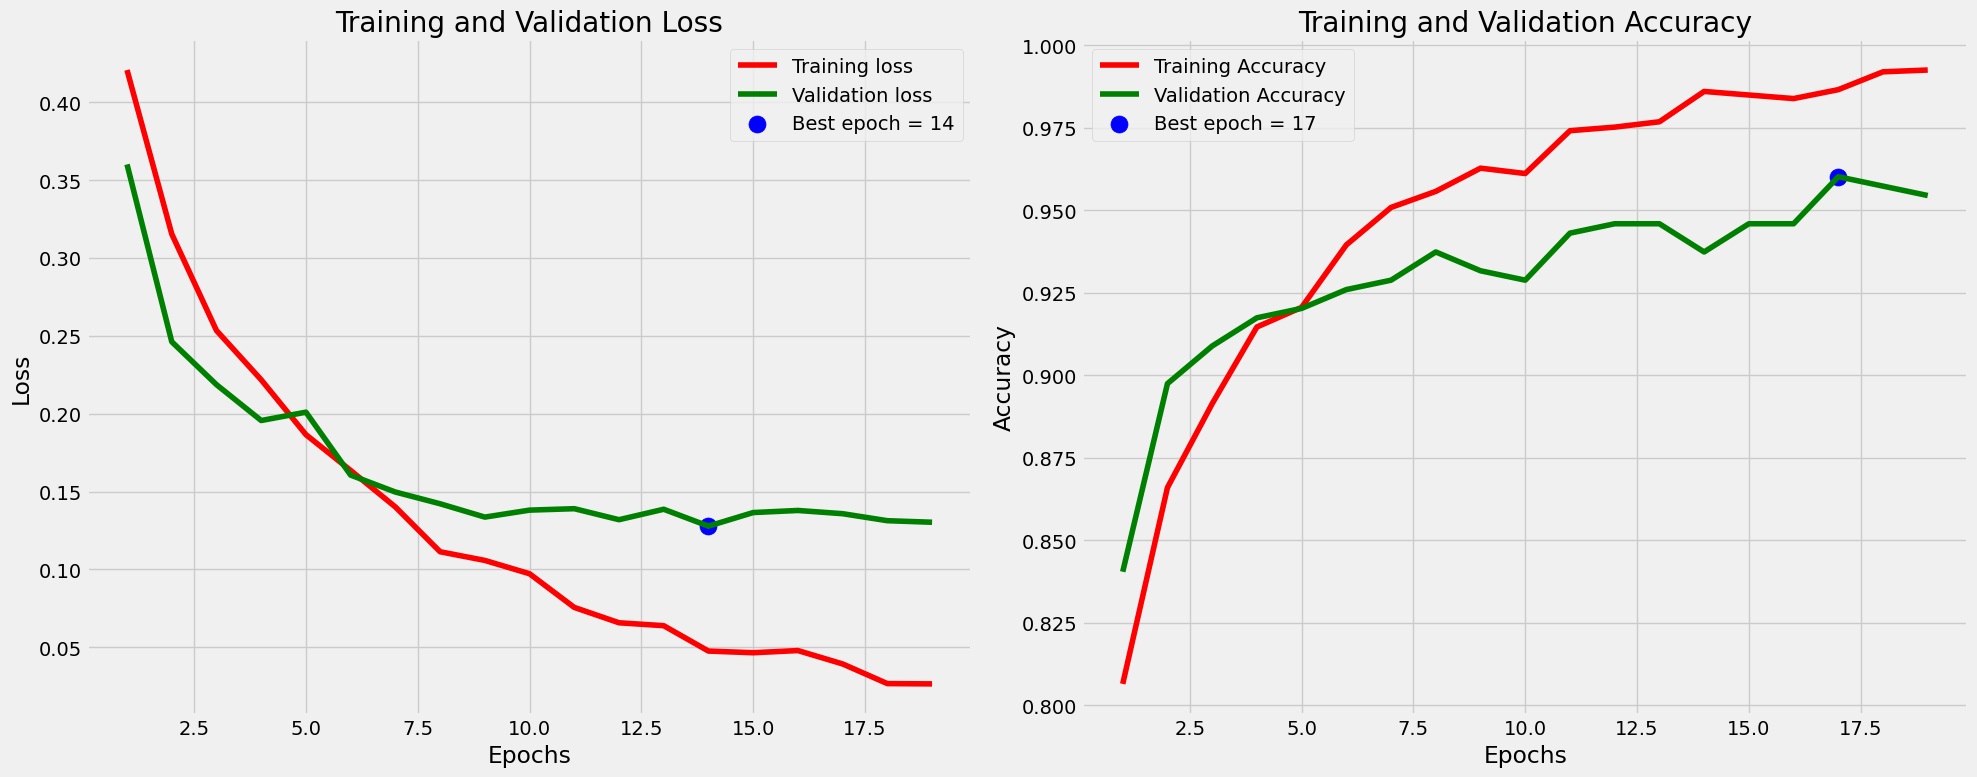

In [ ]:
plot_training(history_fine2)


In [ ]:
# ==========INITIAL EVALUATION ==========
loss2, acc2, precision2, recall2, auc2 = model2.evaluate(val_ds)
print(f"Validation Accuracy: {acc2 * 100:.2f}%")
print(f"Validation Precision: {precision2 * 100:.2f}%")
print(f"Validation Recall: {recall2 * 100:.2f}%")
print(f"Validation AUC: {auc2 * 100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9324 - auc: 0.9850 - loss: 0.1457 - precision: 0.9594 - recall: 0.9066
Validation Accuracy: 93.73%
Validation Precision: 94.89%
Validation Recall: 92.78%
Validation AUC: 98.71%


## Xception Model

In [ ]:
# === Xception preprocessing ===
preprocess_input = tf.keras.applications.xception.preprocess_input


In [ ]:
# Parameters
IMG_SIZE = (299, 299)
BATCH_SIZE = 32
EPOCHS = 50
AUTOTUNE = tf.data.AUTOTUNE

# Load datasets
train_ds = image_dataset_from_directory(train_dir,
                                        image_size=IMG_SIZE,
                                        batch_size=BATCH_SIZE,
                                        label_mode="binary")

val_ds = image_dataset_from_directory(val_dir,
                                      image_size=IMG_SIZE,
                                      batch_size=BATCH_SIZE,
                                      label_mode="binary")

test_ds = image_dataset_from_directory(test_dir,
                                       image_size=IMG_SIZE,
                                       batch_size=BATCH_SIZE,
                                       label_mode="binary")

# === Load Xception base model ===

base_model3 = Xception(include_top=False,
                      weights='imagenet',
                      input_shape=(299, 299, 3))
base_model3.trainable = False  # freeze for transfer learning

# === Build model ===
inputs3 = Input(shape=(299, 299, 3))  # Xception expects 299x299

# Move data augmentation directly into the model
x = tf.keras.layers.RandomFlip("horizontal")(inputs3)
x = tf.keras.layers.RandomRotation(0.1)(x)
x = tf.keras.layers.RandomZoom(0.1)(x)
x = tf.keras.layers.RandomContrast(0.1)(x)

x = preprocess_input(x)
x = base_model3(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs3 = Dense(1, activation='sigmoid')(x)

model3 = Model(inputs3, outputs3)


# === Compile ===
model3.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])
# Custom Callback to track validation accuracy improvement
class ValAccuracyImprovement(Callback):
    def __init__(self):
        super().__init__()
        self.best_val_accuracy = 0.0

    def on_epoch_end(self, epoch, logs=None):
        current_val_accuracy = logs.get('val_accuracy', 0.0)

        if current_val_accuracy > self.best_val_accuracy:
            print(f"\n🔥 Validation accuracy improved from {self.best_val_accuracy:.4f} to {current_val_accuracy:.4f}")
            self.best_val_accuracy = current_val_accuracy
        else:
            print(f"\n❌ Validation accuracy did not improve (Best: {self.best_val_accuracy:.4f}, Current: {current_val_accuracy:.4f})")

val_accuracy_cb3 = ValAccuracyImprovement()  # Custom callback

# === Callbacks ===
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('xception_stroke_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    TensorBoard(log_dir=log_dir),
    val_accuracy_cb3
]
training_start_time3 = time.time()

history = model3.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=callbacks)

# === Phase 2: Fine-tuning ===
base_model3.trainable = True
fine_tune_at = 100  # Freeze early layers

for layer in base_model3.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile with lower LR
model3.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

# Fine-tune training
history_fine3 = model3.fit(train_ds,
                         validation_data=val_ds,
                         epochs=EPOCHS,
                         callbacks=callbacks)
training_end_time3 = time.time()

Found 1850 files belonging to 2 classes.
Found 351 files belonging to 2 classes.
Found 127 files belonging to 2 classes.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.5539 - auc: 0.5804 - loss: 0.6884 - precision: 0.5702 - recall: 0.5786


🔥 Validation accuracy improved from 0.0000 to 0.7350
58/58 ━━━━━━━━━━━━━━━━━━━━ 43s 536ms/step - accuracy: 0.5551 - auc: 0.5821 - loss: 0.6876 - precision: 0.5713 - recall: 0.5801 - val_accuracy: 0.7350 - val_auc: 0.8496 - val_loss: 0.5549 - val_precision: 0.6867 - val_recall: 0.8889 - learning_rate: 1.0000e-04
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.7099 - auc: 0.7897 - loss: 0.5643 - precision: 0.7003 - recall: 0.7421


🔥 Validation accuracy improved from 0.7350 to 0.7920
58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 386ms/step - accuracy: 0.7104 - auc: 0.7901 - loss: 0.5640 - precision: 0.7009 - recall: 0.7424 - val_accuracy: 0.7920 - val_auc: 0.8792 - val_loss: 0.4826 - val_precision: 0.7536 - val_recall: 0.8833 - learning_rate: 1.0000e-04
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7662 - auc: 0.8254 - loss: 0.5179 - precision: 0.7619 - recall: 0.7981


🔥 Validation accuracy improved from 0.7920 to 0.8376
58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 385ms/step - accuracy: 0.7664 - auc: 0.8257 - loss: 0.5176 - precision: 0.7622 - recall: 0.7981 - val_accuracy: 0.8376 - val_auc: 0.8976 - val_loss: 0.4306 - val_precision: 0.8324 - val_recall: 0.8556 - learning_rate: 1.0000e-04
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7713 - auc: 0.8612 - loss: 0.4720 - precision: 0.7719 - recall: 0.7907
❌ Validation accuracy did not improve (Best: 0.8376, Current: 0.8376)
58/58 ━━━━━━━━━━━━━━━━━━━━ 38s 341ms/step - accuracy: 0.7716 - auc: 0.8613 - loss: 0.4719 - precision: 0.7723 - recall: 0.7908 - val_accuracy: 0.8376 - val_auc: 0.9042 - val_loss: 0.4098 - val_precision: 0.8154 - val_recall: 0.8833 - learning_rate: 1.0000e-04
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.7993 - auc: 0.8751 - loss: 0.4512 - precision: 0.7901 - recall: 0.8301


🔥 Validation accuracy improved from 0.8376 to 0.8519
58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 388ms/step - accuracy: 0.7992 - auc: 0.8751 - loss: 0.4512 - precision: 0.7903 - recall: 0.8298 - val_accuracy: 0.8519 - val_auc: 0.9123 - val_loss: 0.3868 - val_precision: 0.8441 - val_recall: 0.8722 - learning_rate: 1.0000e-04
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7985 - auc: 0.8706 - loss: 0.4495 - precision: 0.8012 - recall: 0.8002
❌ Validation accuracy did not improve (Best: 0.8519, Current: 0.8490)
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 351ms/step - accuracy: 0.7984 - auc: 0.8708 - loss: 0.4493 - precision: 0.8014 - recall: 0.8002 - val_accuracy: 0.8490 - val_auc: 0.9159 - val_loss: 0.3742 - val_precision: 0.8508 - val_recall: 0.8556 - learning_rate: 1.0000e-04
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8050 - auc: 0.8887 - loss: 0.4216 - precision: 0.8192 - recall: 0.8081


🔥 Validation accuracy improved from 0.8519 to 0.8632
58/58 ━━━━━━━━━━━━━━━━━━━━ 41s 356ms/step - accuracy: 0.8050 - auc: 0.8887 - loss: 0.4216 - precision: 0.8193 - recall: 0.8077 - val_accuracy: 0.8632 - val_auc: 0.9204 - val_loss: 0.3638 - val_precision: 0.8708 - val_recall: 0.8611 - learning_rate: 1.0000e-04
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8187 - auc: 0.8976 - loss: 0.4075 - precision: 0.8244 - recall: 0.8287
❌ Validation accuracy did not improve (Best: 0.8632, Current: 0.8604)
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - accuracy: 0.8186 - auc: 0.8975 - loss: 0.4075 - precision: 0.8244 - recall: 0.8284 - val_accuracy: 0.8604 - val_auc: 0.9244 - val_loss: 0.3561 - val_precision: 0.8659 - val_recall: 0.8611 - learning_rate: 1.0000e-04
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.8234 - auc: 0.8968 - loss: 0.4051 - precision: 0.8442 - recall: 0.8100
❌ Validation accuracy did not improve (Best: 0.8632, Current: 0.8547)
58/58 ━━━━━━


🔥 Validation accuracy improved from 0.8632 to 0.8689
58/58 ━━━━━━━━━━━━━━━━━━━━ 38s 345ms/step - accuracy: 0.8106 - auc: 0.8920 - loss: 0.4150 - precision: 0.8229 - recall: 0.8094 - val_accuracy: 0.8689 - val_auc: 0.9302 - val_loss: 0.3428 - val_precision: 0.8851 - val_recall: 0.8556 - learning_rate: 1.0000e-04
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.8216 - auc: 0.9001 - loss: 0.3971 - precision: 0.8451 - recall: 0.8058
❌ Validation accuracy did not improve (Best: 0.8689, Current: 0.8661)
58/58 ━━━━━━━━━━━━━━━━━━━━ 22s 379ms/step - accuracy: 0.8215 - auc: 0.9001 - loss: 0.3970 - precision: 0.8449 - recall: 0.8058 - val_accuracy: 0.8661 - val_auc: 0.9306 - val_loss: 0.3413 - val_precision: 0.8844 - val_recall: 0.8500 - learning_rate: 1.0000e-04
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.8360 - auc: 0.9179 - loss: 0.3657 - precision: 0.8504 - recall: 0.8333
❌ Validation accuracy did not improve (Best: 0.8689, Current: 0.8661)
58/58 ━━━━


🔥 Validation accuracy improved from 0.8689 to 0.8718
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - accuracy: 0.8127 - auc: 0.9057 - loss: 0.3878 - precision: 0.8213 - recall: 0.8170 - val_accuracy: 0.8718 - val_auc: 0.9369 - val_loss: 0.3278 - val_precision: 0.8902 - val_recall: 0.8556 - learning_rate: 1.0000e-04
Epoch 14/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8262 - auc: 0.9076 - loss: 0.3818 - precision: 0.8456 - recall: 0.8085
❌ Validation accuracy did not improve (Best: 0.8718, Current: 0.8689)
58/58 ━━━━━━━━━━━━━━━━━━━━ 40s 343ms/step - accuracy: 0.8263 - auc: 0.9076 - loss: 0.3817 - precision: 0.8456 - recall: 0.8085 - val_accuracy: 0.8689 - val_auc: 0.9387 - val_loss: 0.3236 - val_precision: 0.8807 - val_recall: 0.8611 - learning_rate: 1.0000e-04
Epoch 15/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.8422 - auc: 0.9089 - loss: 0.3830 - precision: 0.8531 - recall: 0.8399
❌ Validation accuracy did not improve (Best: 0.8718, Current: 0.8718)
58/58 ━━━━


🔥 Validation accuracy improved from 0.8718 to 0.8746
58/58 ━━━━━━━━━━━━━━━━━━━━ 23s 379ms/step - accuracy: 0.8374 - auc: 0.9155 - loss: 0.3640 - precision: 0.8653 - recall: 0.8076 - val_accuracy: 0.8746 - val_auc: 0.9487 - val_loss: 0.2995 - val_precision: 0.8908 - val_recall: 0.8611 - learning_rate: 1.0000e-04
Epoch 27/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8395 - auc: 0.9173 - loss: 0.3621 - precision: 0.8610 - recall: 0.8237
❌ Validation accuracy did not improve (Best: 0.8746, Current: 0.8746)
58/58 ━━━━━━━━━━━━━━━━━━━━ 22s 373ms/step - accuracy: 0.8395 - auc: 0.9173 - loss: 0.3622 - precision: 0.8609 - recall: 0.8238 - val_accuracy: 0.8746 - val_auc: 0.9493 - val_loss: 0.2994 - val_precision: 0.8908 - val_recall: 0.8611 - learning_rate: 1.0000e-04
Epoch 28/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.8335 - auc: 0.9227 - loss: 0.3563 - precision: 0.8310 - recall: 0.8455
❌ Validation accuracy did not improve (Best: 0.8746, Current: 0.8746)
58/58 ━━━━


🔥 Validation accuracy improved from 0.8746 to 0.8832
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 353ms/step - accuracy: 0.8393 - auc: 0.9239 - loss: 0.3523 - precision: 0.8442 - recall: 0.8338 - val_accuracy: 0.8832 - val_auc: 0.9514 - val_loss: 0.2918 - val_precision: 0.8971 - val_recall: 0.8722 - learning_rate: 1.0000e-04
Epoch 31/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.8333 - auc: 0.9298 - loss: 0.3398 - precision: 0.8290 - recall: 0.8527
❌ Validation accuracy did not improve (Best: 0.8832, Current: 0.8775)
58/58 ━━━━━━━━━━━━━━━━━━━━ 40s 340ms/step - accuracy: 0.8333 - auc: 0.9298 - loss: 0.3399 - precision: 0.8292 - recall: 0.8525 - val_accuracy: 0.8775 - val_auc: 0.9536 - val_loss: 0.2930 - val_precision: 0.9102 - val_recall: 0.8444 - learning_rate: 1.0000e-04
Epoch 32/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.8421 - auc: 0.9217 - loss: 0.3545 - precision: 0.8499 - recall: 0.8339
❌ Validation accuracy did not improve (Best: 0.8832, Current: 0.8803)
58/58 ━━━━


🔥 Validation accuracy improved from 0.8832 to 0.8860
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 336ms/step - accuracy: 0.8345 - auc: 0.9206 - loss: 0.3564 - precision: 0.8407 - recall: 0.8364 - val_accuracy: 0.8860 - val_auc: 0.9538 - val_loss: 0.2865 - val_precision: 0.8933 - val_recall: 0.8833 - learning_rate: 1.0000e-04
Epoch 36/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8454 - auc: 0.9250 - loss: 0.3468 - precision: 0.8510 - recall: 0.8541
❌ Validation accuracy did not improve (Best: 0.8860, Current: 0.8803)
58/58 ━━━━━━━━━━━━━━━━━━━━ 22s 380ms/step - accuracy: 0.8455 - auc: 0.9251 - loss: 0.3467 - precision: 0.8512 - recall: 0.8541 - val_accuracy: 0.8803 - val_auc: 0.9535 - val_loss: 0.2861 - val_precision: 0.9012 - val_recall: 0.8611 - learning_rate: 1.0000e-04
Epoch 37/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.8400 - auc: 0.9271 - loss: 0.3413 - precision: 0.8517 - recall: 0.8340
❌ Validation accuracy did not improve (Best: 0.8860, Current: 0.8803)
58/58 ━━━━


🔥 Validation accuracy improved from 0.8860 to 0.8946
58/58 ━━━━━━━━━━━━━━━━━━━━ 43s 535ms/step - accuracy: 0.7908 - auc: 0.8834 - loss: 0.4400 - precision: 0.7698 - recall: 0.8474 - val_accuracy: 0.8946 - val_auc: 0.9570 - val_loss: 0.2808 - val_precision: 0.8907 - val_recall: 0.9056 - learning_rate: 1.0000e-05
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.8270 - auc: 0.9073 - loss: 0.3843 - precision: 0.8412 - recall: 0.8235
❌ Validation accuracy did not improve (Best: 0.8946, Current: 0.8889)
58/58 ━━━━━━━━━━━━━━━━━━━━ 39s 514ms/step - accuracy: 0.8271 - auc: 0.9074 - loss: 0.3841 - precision: 0.8414 - recall: 0.8237 - val_accuracy: 0.8889 - val_auc: 0.9622 - val_loss: 0.2591 - val_precision: 0.8895 - val_recall: 0.8944 - learning_rate: 1.0000e-05
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.8528 - auc: 0.9184 - loss: 0.3662 - precision: 0.8584 - recall: 0.8562
❌ Validation accuracy did not improve (Best: 0.8946, Current: 0.8946)
58/58 ━━━━━━


🔥 Validation accuracy improved from 0.8946 to 0.9088
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 493ms/step - accuracy: 0.8577 - auc: 0.9341 - loss: 0.3261 - precision: 0.8677 - recall: 0.8562 - val_accuracy: 0.9088 - val_auc: 0.9700 - val_loss: 0.2258 - val_precision: 0.9253 - val_recall: 0.8944 - learning_rate: 1.0000e-05
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8616 - auc: 0.9416 - loss: 0.3081 - precision: 0.8874 - recall: 0.8428
❌ Validation accuracy did not improve (Best: 0.9088, Current: 0.8974)
58/58 ━━━━━━━━━━━━━━━━━━━━ 28s 478ms/step - accuracy: 0.8618 - auc: 0.9417 - loss: 0.3078 - precision: 0.8874 - recall: 0.8432 - val_accuracy: 0.8974 - val_auc: 0.9717 - val_loss: 0.2275 - val_precision: 0.9444 - val_recall: 0.8500 - learning_rate: 1.0000e-05
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.8876 - auc: 0.9537 - loss: 0.2716 - precision: 0.9123 - recall: 0.8669
❌ Validation accuracy did not improve (Best: 0.9088, Current: 0.9088)
58/58 ━━━━━━


🔥 Validation accuracy improved from 0.9088 to 0.9117
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 491ms/step - accuracy: 0.8867 - auc: 0.9597 - loss: 0.2559 - precision: 0.9052 - recall: 0.8721 - val_accuracy: 0.9117 - val_auc: 0.9765 - val_loss: 0.2062 - val_precision: 0.9408 - val_recall: 0.8833 - learning_rate: 1.0000e-05
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8854 - auc: 0.9574 - loss: 0.2597 - precision: 0.8972 - recall: 0.8744
❌ Validation accuracy did not improve (Best: 0.9117, Current: 0.9117)
58/58 ━━━━━━━━━━━━━━━━━━━━ 42s 513ms/step - accuracy: 0.8856 - auc: 0.9575 - loss: 0.2594 - precision: 0.8974 - recall: 0.8747 - val_accuracy: 0.9117 - val_auc: 0.9776 - val_loss: 0.2078 - val_precision: 0.9627 - val_recall: 0.8611 - learning_rate: 1.0000e-05
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8978 - auc: 0.9653 - loss: 0.2397 - precision: 0.9068 - recall: 0.8967


🔥 Validation accuracy improved from 0.9117 to 0.9202
58/58 ━━━━━━━━━━━━━━━━━━━━ 31s 525ms/step - accuracy: 0.8978 - auc: 0.9653 - loss: 0.2397 - precision: 0.9068 - recall: 0.8966 - val_accuracy: 0.9202 - val_auc: 0.9787 - val_loss: 0.1930 - val_precision: 0.9471 - val_recall: 0.8944 - learning_rate: 1.0000e-05
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9010 - auc: 0.9722 - loss: 0.2177 - precision: 0.8950 - recall: 0.9132
❌ Validation accuracy did not improve (Best: 0.9202, Current: 0.9145)
58/58 ━━━━━━━━━━━━━━━━━━━━ 30s 518ms/step - accuracy: 0.9011 - auc: 0.9721 - loss: 0.2177 - precision: 0.8953 - recall: 0.9131 - val_accuracy: 0.9145 - val_auc: 0.9803 - val_loss: 0.1862 - val_precision: 0.9464 - val_recall: 0.8833 - learning_rate: 1.0000e-05
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9127 - auc: 0.9744 - loss: 0.2053 - precision: 0.9252 - recall: 0.9033


🔥 Validation accuracy improved from 0.9202 to 0.9288
58/58 ━━━━━━━━━━━━━━━━━━━━ 31s 528ms/step - accuracy: 0.9127 - auc: 0.9744 - loss: 0.2053 - precision: 0.9252 - recall: 0.9034 - val_accuracy: 0.9288 - val_auc: 0.9809 - val_loss: 0.1801 - val_precision: 0.9480 - val_recall: 0.9111 - learning_rate: 1.0000e-05
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9060 - auc: 0.9686 - loss: 0.2265 - precision: 0.9235 - recall: 0.8895


🔥 Validation accuracy improved from 0.9288 to 0.9316
58/58 ━━━━━━━━━━━━━━━━━━━━ 31s 526ms/step - accuracy: 0.9061 - auc: 0.9687 - loss: 0.2264 - precision: 0.9236 - recall: 0.8897 - val_accuracy: 0.9316 - val_auc: 0.9825 - val_loss: 0.1763 - val_precision: 0.9588 - val_recall: 0.9056 - learning_rate: 1.0000e-05
Epoch 13/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9359 - auc: 0.9840 - loss: 0.1680 - precision: 0.9312 - recall: 0.9459
❌ Validation accuracy did not improve (Best: 0.9316, Current: 0.9316)
58/58 ━━━━━━━━━━━━━━━━━━━━ 30s 517ms/step - accuracy: 0.9357 - auc: 0.9840 - loss: 0.1682 - precision: 0.9311 - recall: 0.9457 - val_accuracy: 0.9316 - val_auc: 0.9843 - val_loss: 0.1674 - val_precision: 0.9535 - val_recall: 0.9111 - learning_rate: 1.0000e-05
Epoch 14/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9369 - auc: 0.9835 - loss: 0.1660 - precision: 0.9446 - recall: 0.9303


🔥 Validation accuracy improved from 0.9316 to 0.9345
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 500ms/step - accuracy: 0.9369 - auc: 0.9835 - loss: 0.1660 - precision: 0.9447 - recall: 0.9301 - val_accuracy: 0.9345 - val_auc: 0.9852 - val_loss: 0.1665 - val_precision: 0.9645 - val_recall: 0.9056 - learning_rate: 1.0000e-05
Epoch 15/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9272 - auc: 0.9826 - loss: 0.1666 - precision: 0.9303 - recall: 0.9261
❌ Validation accuracy did not improve (Best: 0.9345, Current: 0.9288)
58/58 ━━━━━━━━━━━━━━━━━━━━ 42s 514ms/step - accuracy: 0.9272 - auc: 0.9826 - loss: 0.1666 - precision: 0.9304 - recall: 0.9261 - val_accuracy: 0.9288 - val_auc: 0.9863 - val_loss: 0.1599 - val_precision: 0.9532 - val_recall: 0.9056 - learning_rate: 1.0000e-05
Epoch 16/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9261 - auc: 0.9787 - loss: 0.1825 - precision: 0.9350 - recall: 0.9192
❌ Validation accuracy did not improve (Best: 0.9345, Current: 0.9345)
58/58 ━━━━


🔥 Validation accuracy improved from 0.9345 to 0.9402
58/58 ━━━━━━━━━━━━━━━━━━━━ 39s 490ms/step - accuracy: 0.9437 - auc: 0.9896 - loss: 0.1374 - precision: 0.9549 - recall: 0.9368 - val_accuracy: 0.9402 - val_auc: 0.9870 - val_loss: 0.1482 - val_precision: 0.9595 - val_recall: 0.9222 - learning_rate: 1.0000e-05
Epoch 18/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9565 - auc: 0.9898 - loss: 0.1329 - precision: 0.9659 - recall: 0.9497
❌ Validation accuracy did not improve (Best: 0.9402, Current: 0.9402)
58/58 ━━━━━━━━━━━━━━━━━━━━ 40s 478ms/step - accuracy: 0.9565 - auc: 0.9898 - loss: 0.1328 - precision: 0.9659 - recall: 0.9496 - val_accuracy: 0.9402 - val_auc: 0.9866 - val_loss: 0.1562 - val_precision: 0.9704 - val_recall: 0.9111 - learning_rate: 1.0000e-05
Epoch 19/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9498 - auc: 0.9894 - loss: 0.1315 - precision: 0.9536 - recall: 0.9464


🔥 Validation accuracy improved from 0.9402 to 0.9430
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 495ms/step - accuracy: 0.9497 - auc: 0.9894 - loss: 0.1315 - precision: 0.9537 - recall: 0.9464 - val_accuracy: 0.9430 - val_auc: 0.9876 - val_loss: 0.1535 - val_precision: 0.9762 - val_recall: 0.9111 - learning_rate: 1.0000e-05
Epoch 20/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9443 - auc: 0.9876 - loss: 0.1470 - precision: 0.9568 - recall: 0.9348


🔥 Validation accuracy improved from 0.9430 to 0.9459
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 495ms/step - accuracy: 0.9443 - auc: 0.9876 - loss: 0.1468 - precision: 0.9568 - recall: 0.9350 - val_accuracy: 0.9459 - val_auc: 0.9881 - val_loss: 0.1459 - val_precision: 0.9763 - val_recall: 0.9167 - learning_rate: 1.0000e-05
Epoch 21/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9476 - auc: 0.9910 - loss: 0.1237 - precision: 0.9554 - recall: 0.9424


🔥 Validation accuracy improved from 0.9459 to 0.9487
58/58 ━━━━━━━━━━━━━━━━━━━━ 41s 488ms/step - accuracy: 0.9476 - auc: 0.9910 - loss: 0.1238 - precision: 0.9554 - recall: 0.9424 - val_accuracy: 0.9487 - val_auc: 0.9885 - val_loss: 0.1358 - val_precision: 0.9709 - val_recall: 0.9278 - learning_rate: 1.0000e-05
Epoch 22/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9550 - auc: 0.9917 - loss: 0.1190 - precision: 0.9667 - recall: 0.9452


🔥 Validation accuracy improved from 0.9487 to 0.9573
58/58 ━━━━━━━━━━━━━━━━━━━━ 43s 523ms/step - accuracy: 0.9550 - auc: 0.9918 - loss: 0.1190 - precision: 0.9667 - recall: 0.9452 - val_accuracy: 0.9573 - val_auc: 0.9901 - val_loss: 0.1299 - val_precision: 0.9769 - val_recall: 0.9389 - learning_rate: 1.0000e-05
Epoch 23/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9508 - auc: 0.9906 - loss: 0.1214 - precision: 0.9576 - recall: 0.9455
❌ Validation accuracy did not improve (Best: 0.9573, Current: 0.9573)
58/58 ━━━━━━━━━━━━━━━━━━━━ 38s 478ms/step - accuracy: 0.9509 - auc: 0.9906 - loss: 0.1212 - precision: 0.9578 - recall: 0.9456 - val_accuracy: 0.9573 - val_auc: 0.9904 - val_loss: 0.1259 - val_precision: 0.9769 - val_recall: 0.9389 - learning_rate: 1.0000e-05
Epoch 24/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9680 - auc: 0.9935 - loss: 0.1027 - precision: 0.9716 - recall: 0.9672
❌ Validation accuracy did not improve (Best: 0.9573, Current: 0.9573)
58/58 ━━━━

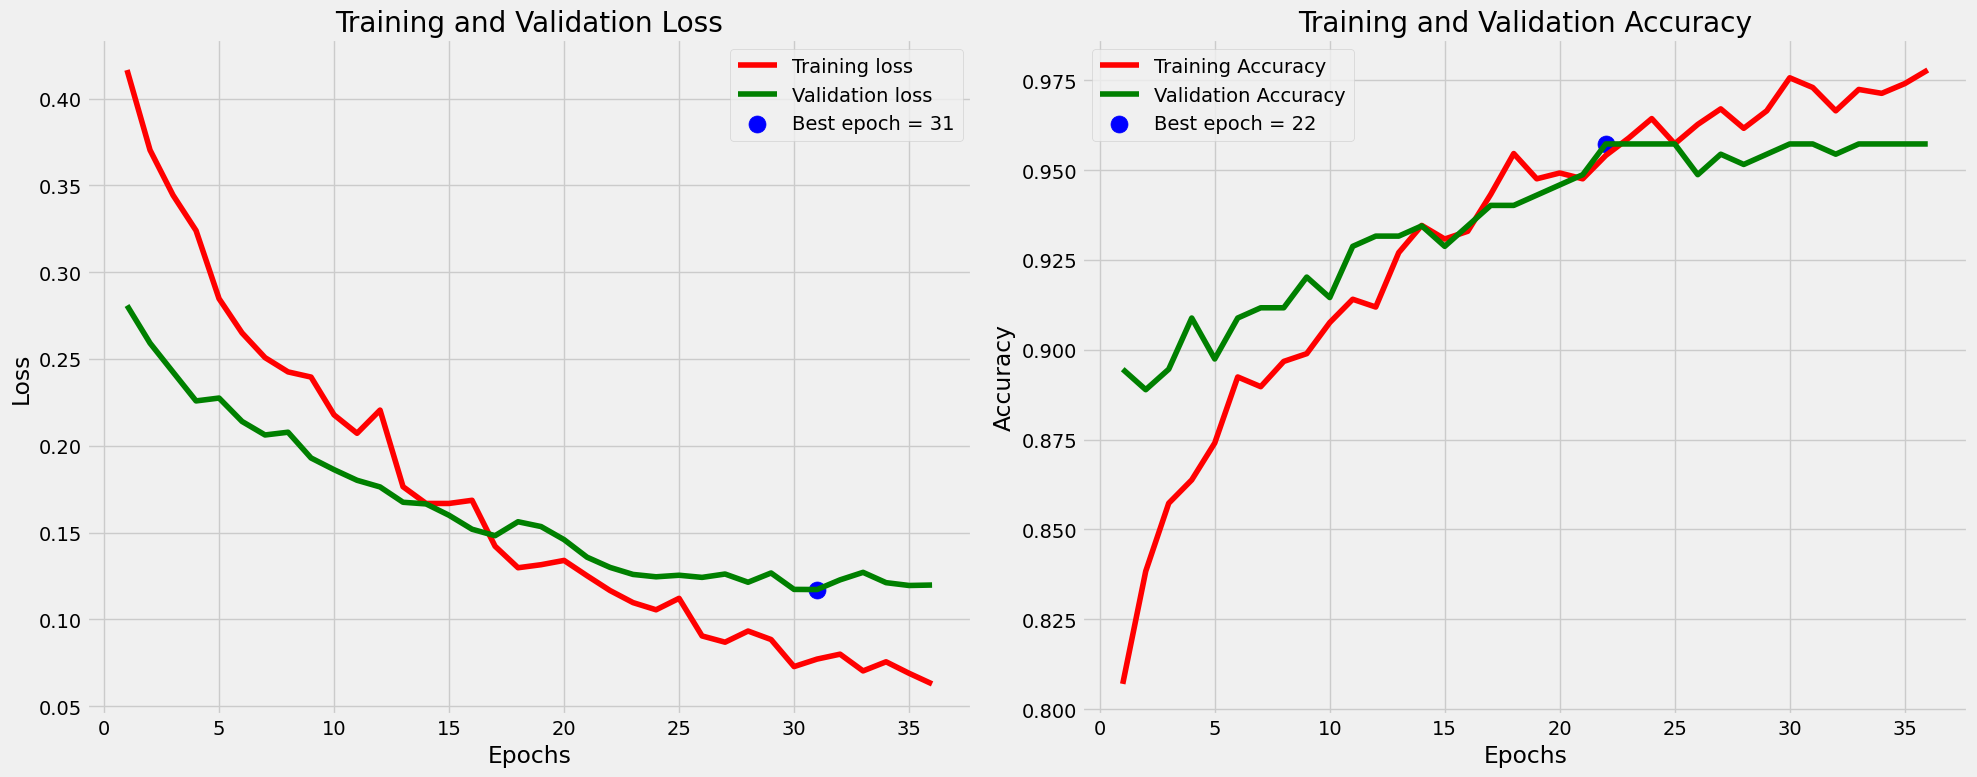

In [ ]:
plot_training(history_fine3)


In [ ]:
# ==========INITIAL EVALUATION ==========
loss3, acc3, precision3, recall3, auc3 = model3.evaluate(val_ds)
print(f"Validation Accuracy: {acc3 * 100:.2f}%")
print(f"Validation Precision: {precision3 * 100:.2f}%")
print(f"Validation Recall: {recall3 * 100:.2f}%")
print(f"Validation AUC: {auc3 * 100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 273ms/step - accuracy: 0.9544 - auc: 0.9918 - loss: 0.1225 - precision: 0.9742 - recall: 0.9300
Validation Accuracy: 95.73%
Validation Precision: 97.69%
Validation Recall: 93.89%
Validation AUC: 99.17%


<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#28a745; overflow:hidden"><b> Evaluate Models ✅ </b></div>

## DenseNet

In [ ]:
# ========== FINAL EVALUATION ==========
loss, acc, precision, recall, auc = model1.evaluate(test_ds)
print(f"Test Accuracy: {acc * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")
print(f"Test AUC: {auc * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step - accuracy: 0.9739 - auc: 0.9964 - loss: 0.1008 - precision: 0.9726 - recall: 0.9767
Test Accuracy: 96.85%
Test Precision: 98.36%
Test Recall: 95.24%
Test AUC: 99.44%


Found 127 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step

Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.95      0.98      0.97        64
      Stroke       0.98      0.95      0.97        63

    accuracy                           0.97       127
   macro avg       0.97      0.97      0.97       127
weighted avg       0.97      0.97      0.97       127

Confusion matrix, without normalization
[[63  1]
 [ 3 60]]


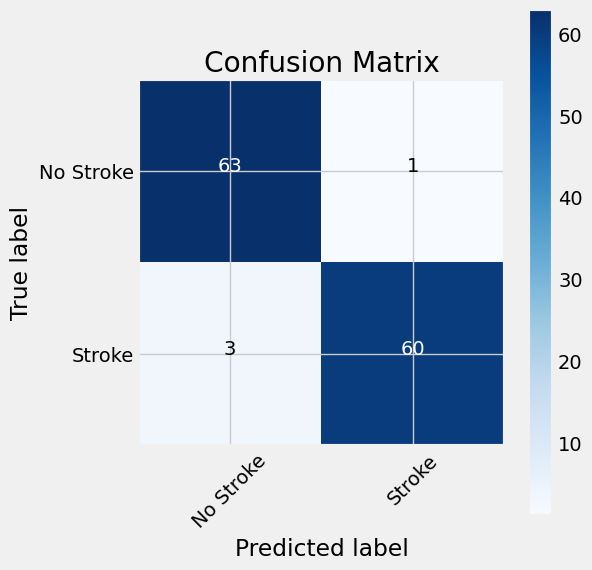

Training started at: 1749313072.9468184
Training ended at: 1749314806.1260586
Total training duration: 1733.18 seconds


In [ ]:
test_ds_224 = image_dataset_from_directory(test_dir,
                                           image_size=(224, 224),
                                           batch_size=BATCH_SIZE,
                                           label_mode="binary")


# === EVALUATION ON TEST SET ===
y_true = []
y_pred = []

for images, labels in test_ds_224:
    preds = model1.predict(images)
    y_pred.extend((preds > 0.5).astype("int32").flatten())
    y_true.extend(labels.numpy().astype("int32").flatten())

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["No Stroke", "Stroke"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes=["No Stroke", "Stroke"], title='Confusion Matrix')

# Basic computational efficiency (training time)
print(f"Training started at: {training_start_time1}")
print(f"Training ended at: {training_end_time1}")
print(f"Total training duration: {training_end_time1 - training_start_time1:.2f} seconds")


## ResNet50

In [ ]:
# ========== FINAL EVALUATION ==========
loss, acc, precision, recall, auc = model2.evaluate(test_ds)
print(f"Test Accuracy: {acc * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")
print(f"Test AUC: {auc * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 718ms/step - accuracy: 0.9488 - auc: 0.9904 - loss: 0.1519 - precision: 1.0000 - recall: 0.9013
Test Accuracy: 94.49%
Test Precision: 100.00%
Test Recall: 88.89%
Test AUC: 98.92%


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.94      1.00      0.97        64
      Stroke       1.00      0.94      0.97        63

    accuracy                           0.97       127
   macro avg       0.97      0.97      0.97       127
weighted avg       0.97      0.97      0.97       127

Confusion matrix, without normalization
[[64  0]
 [ 4 59]]


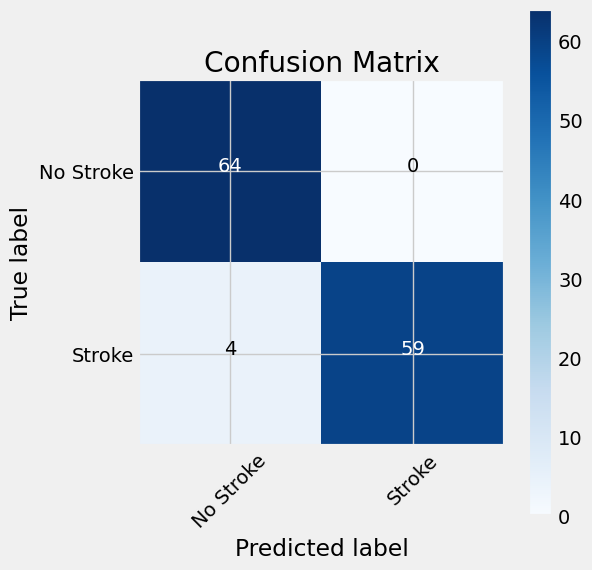

Training started at: 1749314810.9142988
Training ended at: 1749315465.33274
Total training duration: 654.42 seconds


In [ ]:
# === EVALUATION ON TEST SET ===
y_true = []
y_pred = []

for images, labels in test_ds_224:
    preds = model2.predict(images)
    y_pred.extend((preds > 0.5).astype("int32").flatten())
    y_true.extend(labels.numpy().astype("int32").flatten())

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["No Stroke", "Stroke"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes=["No Stroke", "Stroke"], title='Confusion Matrix')

# Basic computational efficiency (training time)
print(f"Training started at: {training_start_time2}")
print(f"Training ended at: {training_end_time2}")
print(f"Total training duration: {training_end_time2 - training_start_time2:.2f} seconds")


## Xception

In [ ]:
# ========== FINAL EVALUATION ==========
loss, acc, precision, recall, auc = model3.evaluate(test_ds)
print(f"Test Accuracy: {acc * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")
print(f"Test AUC: {auc * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - accuracy: 0.9603 - auc: 0.9960 - loss: 0.0998 - precision: 0.9890 - recall: 0.9282
Test Accuracy: 96.85%
Test Precision: 98.36%
Test Recall: 95.24%
Test AUC: 99.73%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step

Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.95      0.98      0.97        64
      Stroke       0.98      0.95      0.97        63

    accuracy                           0.97       127
   macro avg       0.97      0.97      0.97       127
weighted avg       0.97      0.97      0.97       127

Confusion matrix, without normalization
[[63  1]
 [ 3 60]]


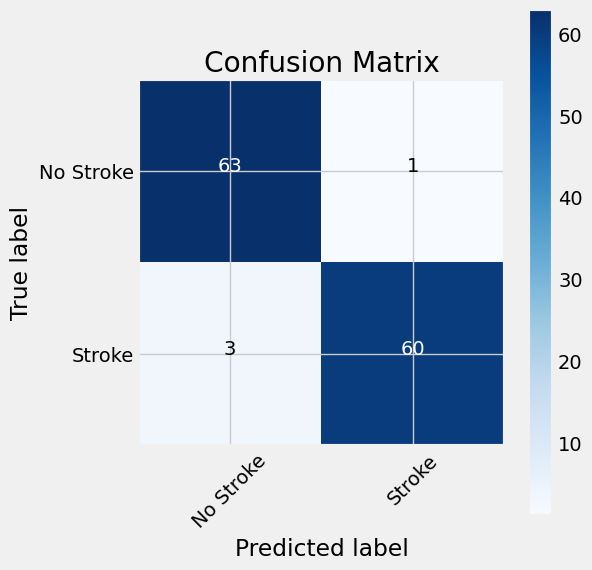

Training started at: 1749315470.7237892
Training ended at: 1749317777.8262725
Total training duration: 2307.10 seconds


In [ ]:
# === EVALUATION ON TEST SET ===
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model3.predict(images)
    y_pred.extend((preds > 0.5).astype("int32").flatten())
    y_true.extend(labels.numpy().astype("int32").flatten())

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["No Stroke", "Stroke"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes=["No Stroke", "Stroke"], title='Confusion Matrix')

# Basic computational efficiency (training time)
print(f"Training started at: {training_start_time3}")
print(f"Training ended at: {training_end_time3}")
print(f"Total training duration: {training_end_time3 - training_start_time3:.2f} seconds")


<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#28a745; overflow:hidden"><b> Save Models ✅ </b></div>

In [ ]:
model1.save('DenseNet121.keras')
model3.save("Xception.keras")
model2.save("ResNet50.keras")
model1.save('/content/drive/MyDrive/DenseNet121.keras')
model2.save('/content/drive/MyDrive/ResNet50.keras')
model3.save('/content/drive/MyDrive/Xception.keras')


In [ ]:
results = {
    "DenseNet121": {"Accuracy": acc1, "Precision": precision1, "Recall": recall1, "AUC": auc1},
    "ResNet50": {"Accuracy": acc2, "Precision": precision2, "Recall": recall2, "AUC": auc2},
    "Xception": {"Accuracy": acc3, "Precision": precision3, "Recall": recall3, "AUC": auc3}
}


In [ ]:

def plot_model_comparison(results):
    labels = list(results.keys())
    accuracy = [results[m]["Accuracy"] for m in labels]
    precision = [results[m]["Precision"] for m in labels]
    recall = [results[m]["Recall"] for m in labels]
    auc = [results[m]["AUC"] for m in labels]

    x = range(len(labels))
    width = 0.2

    plt.figure(figsize=(10, 6))
    plt.bar([p - 1.5*width for p in x], accuracy, width=width, label="Accuracy")
    plt.bar([p - 0.5*width for p in x], precision, width=width, label="Precision")
    plt.bar([p + 0.5*width for p in x], recall, width=width, label="Recall")
    plt.bar([p + 1.5*width for p in x], auc, width=width, label="AUC")

    plt.xticks(x, labels)
    plt.ylabel("Score")
    plt.title("Model Performance Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_model_line_chart(results):
    metrics = ["Accuracy", "Precision", "Recall", "AUC"]
    models = list(results.keys())

    plt.figure(figsize=(10, 6))

    for model in models:
        values = [results[model][metric] for metric in metrics]
        plt.plot(metrics, values, marker='o', label=model)

    plt.ylabel("Score")
    plt.title("Model Metric Comparison")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


In [ ]:

def plot_model_radar_chart(results):
    labels = list(results.keys())
    metrics = ["Accuracy", "Precision", "Recall", "AUC"]
    num_metrics = len(metrics)

    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    for model in labels:
        values = [results[model][metric] for metric in metrics]
        values += values[:1]
        ax.plot(angles, values, label=model)
        ax.fill(angles, values, alpha=0.1)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    ax.set_ylim(0, 1)
    plt.title("Model Performance Radar Chart", y=1.08)
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()


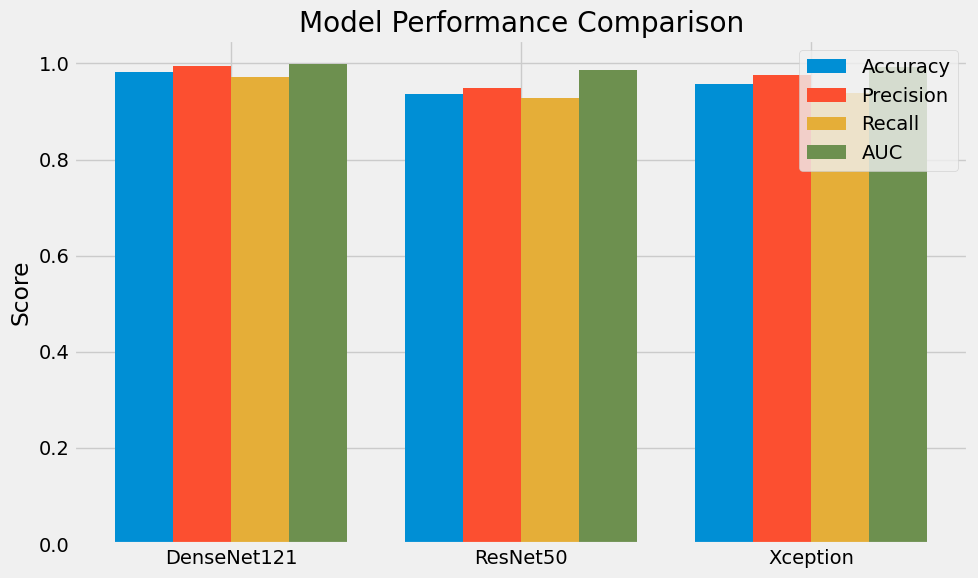

In [ ]:
plot_model_comparison(results)


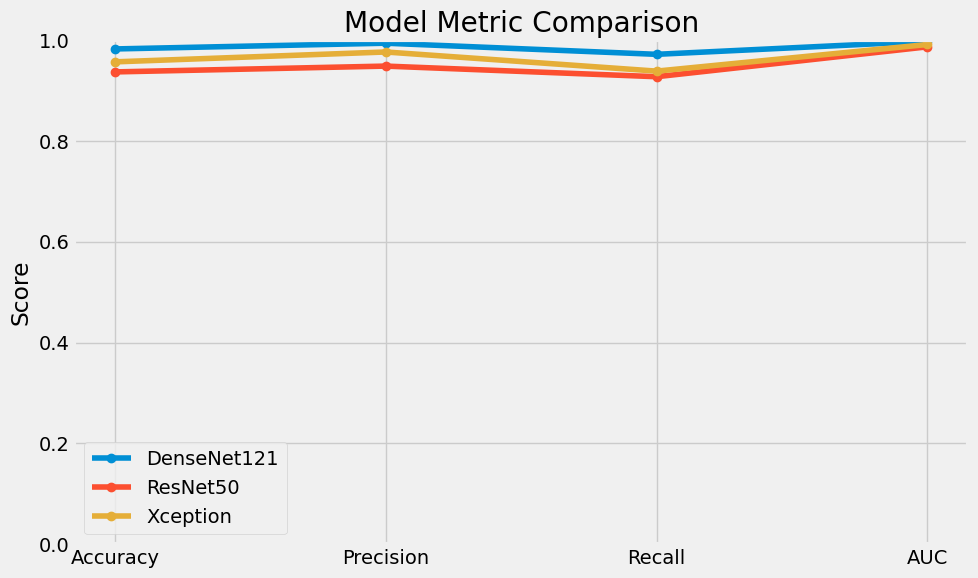

In [ ]:
plot_model_line_chart(results)

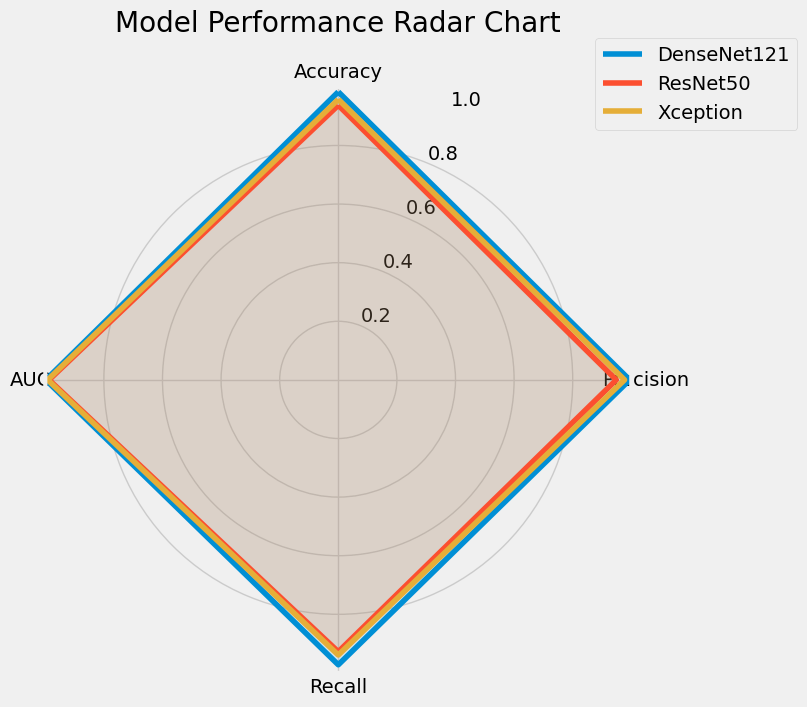

In [ ]:
plot_model_radar_chart(results)

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#28a745; overflow:hidden"><b> Make Prediction 🎯 </b></div>